In [5]:
# the usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [6]:
X = pd.read_csv('./data/processed_first_X_15.csv')
y = pd.read_csv('./data/processed_first_y_15.csv')

In [7]:
train_df = X.copy()
train_df['diabetes'] = y
train_df.head()

,d1_glucose_max,glucose_apache,h1_glucose_max,h1_glucose_min,bmi,weight,d1_bun_max,bun_apache,d1_bun_min,d1_glucose_min,d1_creatinine_max,d1_creatinine_min,creatinine_apache,arf_apache,diabetes
0,156.0,127.0,156.0,156.0,31.242126,77.5,12.0,12.0,12.0,127.0,0.70,0.70,0.70,0,0
1,175.0,118.0,140.0,134.0,20.976012,58.5,12.0,19.0,12.0,118.0,0.80,0.80,0.97,0,1
2,218.0,218.0,140.0,134.0,28.622530,80.4,7.0,7.0,7.0,129.0,0.68,0.68,0.68,0,1
3,97.0,97.0,140.0,134.0,23.474146,68.0,31.0,31.0,31.0,97.0,2.64,2.64,2.64,1,0
4,136.0,108.0,136.0,136.0,25.827271,70.4,20.0,20.0,20.0,108.0,1.20,1.20,1.20,0,0


In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=18)

In [9]:
y_train = np.array(y_train).ravel()
y_val = np.array(y_val).ravel()

## Logistic Regression

### Baseline Score With 1 Feature: .798

In [10]:
X_train_1 = X_train[['d1_glucose_max']]
X_val_1 = X_val[['d1_glucose_max']]

In [11]:
# without regularization
lm1 = LogisticRegression(C=1000)
lm1.fit(X_train_1, y_train)

LogisticRegression(C=1000)

In [12]:
yhat_val_1 = lm1.predict(X_val_1)
yhat_train = lm1.predict(X_train_1)

In [13]:
lm1.coef_, lm1.intercept_

(array([[0.01098291]]), array([-3.31716356]))

In [14]:
print(lm1.score(X_train_1, y_train))
print(lm1.score(X_val_1,y_val))

0.7984393757503001
0.7985594237695078


In [15]:
print("Default Threshold TRAIN:")
print("Precision: {:6.4f},   Recall: {:6.4f} \nF1: {:6.4f}".format(precision_score(y_train, yhat_train), 
                                                     recall_score(y_train, yhat_train),
                                                     f1_score(y_train, yhat_train)))
print("Default Threshold V:")
print("Precision: {:6.4f},   Recall: {:6.4f} \nF1: {:6.4f}".format(precision_score(y_val, yhat_val_1), 
                                                     recall_score(y_val, yhat_val_1),
                                                     f1_score(y_val, yhat_val_1)))

Default Threshold TRAIN:
Precision: 0.6072,   Recall: 0.2106 
F1: 0.3127
Default Threshold V:
Precision: 0.5913,   Recall: 0.2115 
F1: 0.3115


In [20]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_hat_1 = (model.predict_proba(X_val_1)[:, 1] >= threshold)
    diabetes_confusion_1 = confusion_matrix(y_val, y_hat_1)
    plt.figure(dpi=150)
    sns.heatmap(diabetes_confusion_1, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['pred no', 'pred yes'],
           yticklabels=['actual no', 'actual yes']);
    plt.title('baseline confusion matrix')
    plt.savefig('../../project-checkpoints/baseline_confusion.png')
    # plt.xlabel('prediction')
    # plt.ylabel('actual')

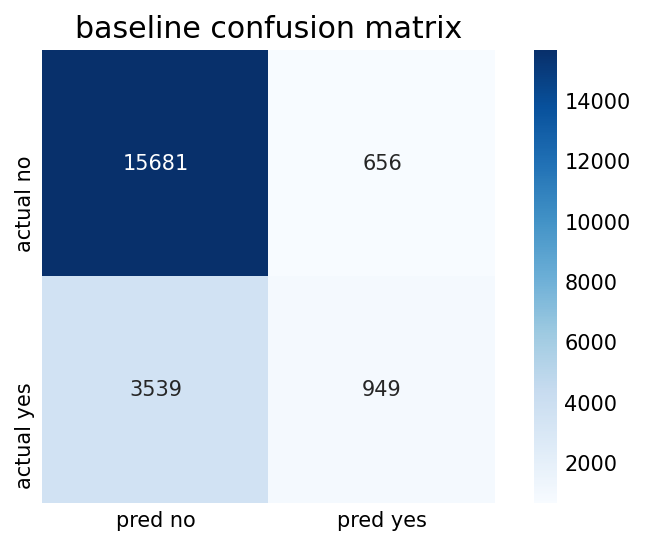

In [22]:
make_confusion_matrix(lm1)

### Score With 10 Features: .800

In [23]:
sts = StandardScaler()
sts.fit(X_train)

StandardScaler()

In [24]:
X_train_scale = sts.transform(X_train)
X_val_scale = sts.transform(X_val)

In [25]:
# with L2 regularization
lm_l2 = LogisticRegression(C=1).fit(X_train_scale, y_train)

In [26]:
# with L1 regularization
lm_l1 = LogisticRegression(C=1, solver='liblinear',penalty='l1').fit(X_train_scale, y_train)

In [27]:
yhat_l2_val = lm_l2.predict(X_val_scale)
yhat_l1_val = lm_l1.predict(X_val_scale)

In [28]:
feat_14 = X_train.columns

In [29]:
list(zip(feat_14,lm_l2.coef_[0,:]))

[('d1_glucose_max', 1.1658401788568638),
 ('glucose_apache', -0.1659023790988181),
 ('h1_glucose_max', -0.11558507011771064),
 ('h1_glucose_min', -0.0008315773490750785),
 ('bmi', 0.23425463440627362),
 ('weight', 0.12382683217920447),
 ('d1_bun_max', -0.034777352665689154),
 ('bun_apache', -0.05890596318304897),
 ('d1_bun_min', 0.2597423859162611),
 ('d1_glucose_min', -0.05437087516328682),
 ('d1_creatinine_max', -0.39382329890349976),
 ('d1_creatinine_min', 0.314992521523454),
 ('creatinine_apache', 0.0356188257273821),
 ('arf_apache', 0.21508086300178011)]

In [31]:
print('Train Score (L2): ',lm_l2.score(X_train_scale, y_train))
print('Val Score (L2): ',lm_l2.score(X_val_scale,y_val))
print('Train Score (L1): ',lm_l1.score(X_train_scale, y_train))
print('Val Score (L1): ',lm_l1.score(X_val_scale,y_val))

Train Score (L2):  0.802797118847539
Val Score (L2):  0.802016806722689
Train Score (L1):  0.802797118847539
Val Score (L1):  0.802016806722689


In [32]:
print("L2 Regularization:")
print("Precision: {:6.4f},   Recall: {:6.4f},\nF1: {:6.4f}\n".format(precision_score(y_val, yhat_l2_val), 
                                                     recall_score(y_val, yhat_l2_val),
                                                     f1_score(y_val,yhat_l2_val)))

print("L1 Regularization:")
print("Precision: {:6.4f},   Recall: {:6.4f},\nF1: {:6.4f}\n".format(precision_score(y_val, yhat_l1_val), 
                                                     recall_score(y_val, yhat_l1_val),
                                                     f1_score(y_val,yhat_l1_val)))

L2 Regularization:
Precision: 0.5943,   Recall: 0.2562,
F1: 0.3581

L1 Regularization:
Precision: 0.5944,   Recall: 0.2560,
F1: 0.3579



In [33]:
def make_confusion_matrix_10(model, threshold=0.5):
    y_hat = (model.predict_proba(X_val_scale)[:, 1] >= threshold)
    diabetes_confusion = confusion_matrix(y_val, y_hat)
    
    plt.figure(dpi=300)
    sns.heatmap(diabetes_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['pred no', 'pred yes'],
           yticklabels=['actual no', 'actual yes']);
    plt.title('Confusion Matrix -- Limited Features')
    plt.savefig('../images/graphs/tenfeat_confusion.png')
    
    # plt.xlabel('prediction')
    # plt.ylabel('actual')

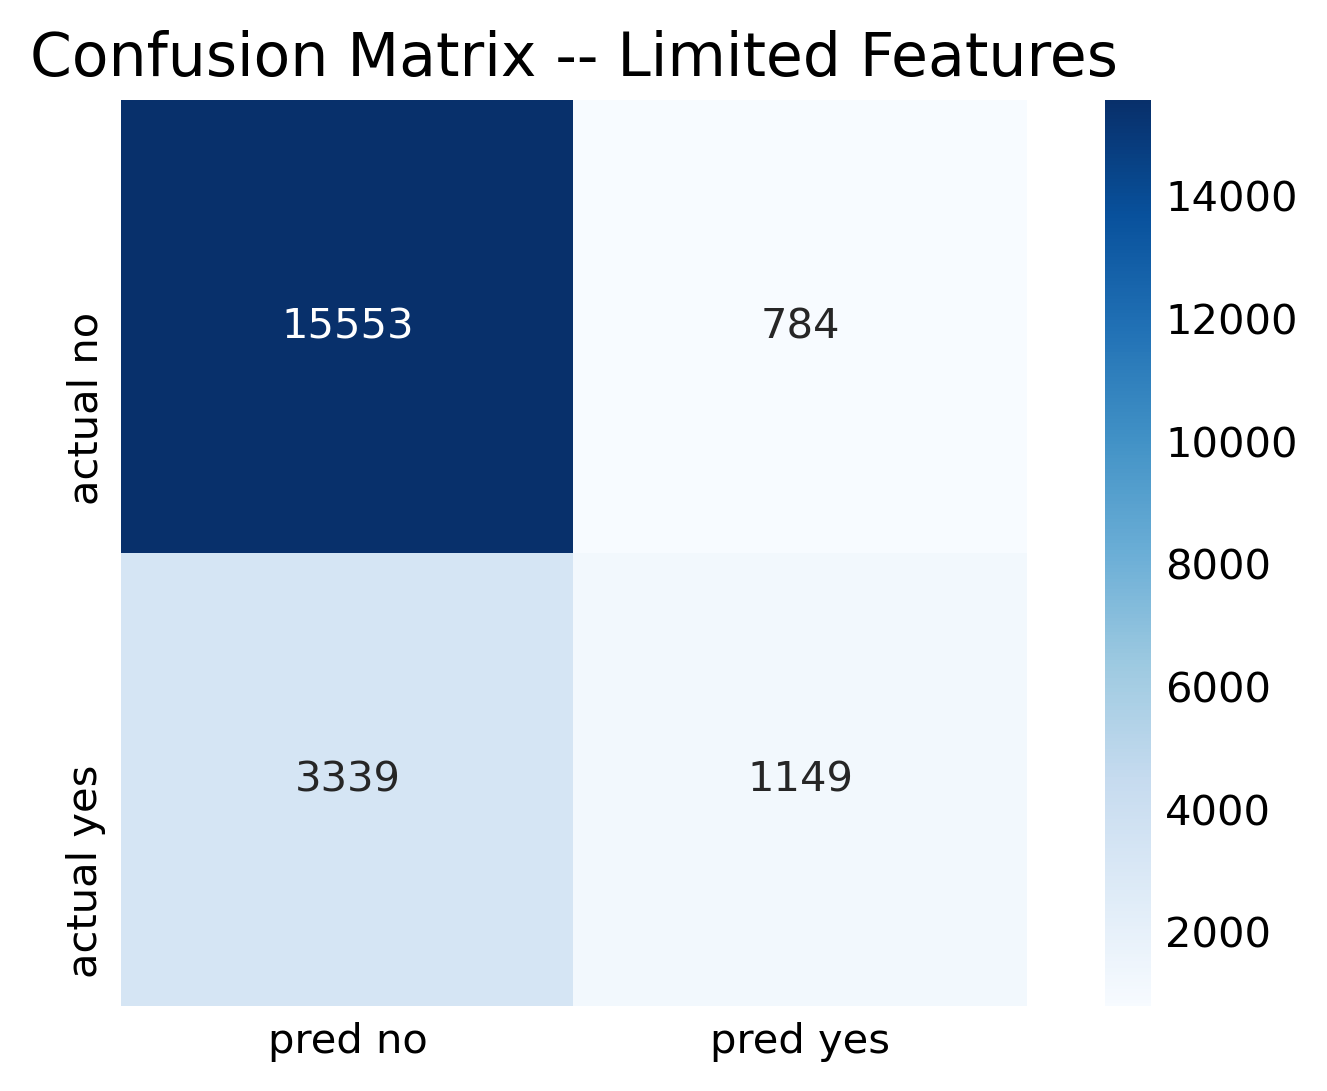

In [34]:
make_confusion_matrix_10(lm_l1)

## Random Forest

In [35]:
rf = RandomForestClassifier(n_estimators=100,class_weight={0: 1, 1: 4})
rf.fit(X_train,y_train)
yhat_val = rf.predict(X_val)

In [36]:
print(rf.score(X_train,y_train))
print(rf.score(X_val,y_val))
print(f1_score(y_val,yhat_val))

0.9990756302521009
0.8081152460984393
0.43076923076923074


In [39]:
list(zip(X_val.columns,rf.feature_importances_))

[('d1_glucose_max', 0.18464240397988824),
 ('glucose_apache', 0.13242192880741183),
 ('h1_glucose_max', 0.05401754488139581),
 ('h1_glucose_min', 0.048777136438599066),
 ('bmi', 0.10210514685447623),
 ('weight', 0.087203268110789),
 ('d1_bun_max', 0.04556072321421993),
 ('bun_apache', 0.04190156570929291),
 ('d1_bun_min', 0.046486680205152495),
 ('d1_glucose_min', 0.07620102255706135),
 ('d1_creatinine_max', 0.06242291287931199),
 ('d1_creatinine_min', 0.06059454658367056),
 ('creatinine_apache', 0.05278200311766923),
 ('arf_apache', 0.004883116661061419)]